# Code Description
This code contains many functions for testing regularization methods across parameter sets and noise realizations

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22
Regularization is applied through use of scipy.optimize.curve_fit in the estimate_parameters function

Application of NLLS and regularization across parameters and noise realization can be seen below

Deep neural network (DNN) regularization models are generated using the Neural Network Regularization file

In general, you will be adjusting SNR below and changing the parameter sets under "Use prior distributions of c1, c2, T21, and T22, then evaluating how effective our different estimation methods are

Numerical method to calculate biased CRLB is currently under progress, so work with Dr. Balan to get that sorted

This code was primarily written by Ryan Neff (RN) and then furthur developed by Griffin Hampton (GSH)

This is the code that is intended to be used during the manuscript that RN is writing

# Import Packages

In [1]:
#%matplotlib widget
import h5py
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from keras.models import load_model
from datetime import date
import pickle

# Options

In [2]:
load_data = False
data_date_oi = "29Nov22"
load_noise = True      #The gold standard of noise realizations is standardNoise_28Nov22.pkl
noise_date_oi = "28Nov22"

sinNR_opt = True
avgNR_opt = True
GCV_opt = True
load_fig2 = False
load_unreg = False

explore_corners = False

eval_nonReg = True
eval_orc_avg = True
eval_orc_var = True
eval_GCV = False

post_normalize_data = False

# Define Parameters

In [3]:
SNR = [100]
n_elements = 128
#Weighting term to ensure the c_i and T2_i are roughly the same magnitude
ob_weight = 100
n_noise_realizations = 500 #500

num_multistarts = 10

agg_weights = np.array([1, 1, 1/ob_weight, 1/ob_weight])

upper_bound = [2,2,100,300] #Set upper bound on parameters c1, c2, T21, T22, respectively
initial = (0.5, 0.5, 30, 150) #Set initial guesses

tdata = np.linspace(0, 635, n_elements)
lambdas = np.append(0, np.logspace(-7,1,51))

###################### Parameters Loop Through
c1_set = [0.4]#[0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]
c2_set = 1-np.array(c1_set)
T21_set = [10,20,30,40,50]
T22_set = [70,90,110,130,150]

param_name_list = ['c1','c2','T21','T22']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

# Define General Functions

### Small Helper Functions

In [4]:
########################### Simple Functions ##############################
# Two parameter definition of s(t) with regularization parameter lambda
def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_tilde(lam, SA = 1):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    def Gt_lam(t, con1, con2, tau1, tau2):
        return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

def G_tilde_linear(T21, T22, lam):
    def G_linear(t, c1, c2):
        return np.append(G(t, c1, c2, T21, T22), [lam*c1, lam*c2])
    return G_linear

def add_noise(data,SNR):
    #returns a noised vector of data using the SNR given
    sigma = 1/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

def construct_paramList(c1_list, T21_list, T22_list):
    preList = [item for item in itertools.product(c1_list, T21_list, T22_list)]
    postList = [list(elem) for elem in preList]
    [elem.insert(1,1-elem[0]) for elem in postList]
    return postList

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def calc_improvement(old, new):
    return (old - new)/old

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1,4))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

### Parameter Estimation Functions

In [5]:
def estimate_parameters(data, lam, n_initials = num_multistarts):
    #Pick n_initials random initial conditions within the bound, and choose the one giving the lowest model-data mismatch residual
    random_residuals = []
    estimates = np.zeros((4,n_initials))
    data_start = np.abs(data[0])
    data_tilde = np.append(data, [0,0,0,0]) # Adds zeros to the end of the regularization array for the param estimation
    
    for i in range(n_initials):
        np.random.seed(i)
        ic1 = np.random.uniform(0,1)
        ic2 = 1-ic1
        ic1 = ic1*data_start
        ic2 = ic2*data_start
        iT21 = np.random.uniform(0,upper_bound[-2])
        iT22 = np.random.uniform(iT21,upper_bound[-1])
        p0 = [ic1,ic2,iT21,iT22]
        up_bnd = upper_bound*np.array([data_start, data_start, 1, 1])
        assert(np.size(up_bnd) == np.size(p0))
        
        try:
            popt, cov = curve_fit(G_tilde(lam), tdata, data_tilde, bounds = (0, up_bnd), p0=p0, max_nfev = 4000)
        except:
            popt = [0,0,1,1]
            print("Max feval reached")
        
        popt = check_param_order(popt) #Require T22>T21
        estimates[:,i] = popt
        estimated_model = G(tdata, *popt)
        
        residual = np.sum((estimated_model - data)**2)
        random_residuals.append(residual)
    min_residual_idx = np.argmin(random_residuals)
    min_residual_estimates = estimates[:,min_residual_idx]
 
    return min_residual_estimates

def generate_all_estimates(param_combos, SNR_mat, noise_mat, lambdas, n_NR = n_noise_realizations):
    #Generates a comprehensive matrix of all parameter estimates for all param combinations, 
    #noise realizations, SNR values, and lambdas of interest

    all_estimates = np.zeros((len(param_combos),len(SNR_mat), len(noise_mat), len(lambdas), 4))
    all_RSS = np.zeros((len(param_combos),len(SNR_mat), len(noise_mat), len(lambdas)))
    
    for iCombo in trange(len(param_combos)): #Loop through all parameter combinations
        pCombo = param_combos[iCombo]
        underlying = G(tdata, *pCombo)

        for iSNR in range(len(SNR_mat)):    #Loop through different SNR values
            all_noise = underlying + (1/SNR_mat[iSNR])*noise_mat
            assert(all_noise.shape == noise_mat.shape)

            for nr in range(n_NR):    #Loop through all noise realizations
                noise_data = all_noise[nr,:]

                for iLam in range(len(lambdas)):    #Loop through all lambda values
                    lam = lambdas[iLam]
                    param_estimates = estimate_parameters(noise_data, lam)
                    all_estimates[iCombo, iSNR, nr, iLam, :] = param_estimates

                    estimated_model = G(tdata, *param_estimates)
                    all_RSS[iCombo, iSNR, nr, iLam] = np.sum((estimated_model - noise_data)**2)

    return all_estimates, all_RSS

def make_patchwork_avgNR(paramCombos, lambdas, nReps = n_noise_realizations, verbose=False, aggregate = False):
    # This is the first oracle method - minimum MSE lambda - avg MSE is found out of nReps
    # Each lambda value is solved for nReps
    # Given a prior set of true parameters and a parameter of interest,
    #find lambdas which give lowest MSE for each combination of parameters
    n_combos = len(paramCombos)
    n_lambdas = len(lambdas)

    if aggregate:
        lam_stored = 1
    else:
        lam_stored = 4
    
    bias_array = np.zeros((n_combos, n_lambdas, lam_stored))
    var_array = np.zeros((n_combos, n_lambdas, lam_stored))
    # MSE_array = np.zeros((n_combos, n_lambdas, lam_stored))
    # min_MSE_array = np.zeros((n_combos, lam_stored))
    # unreg_MSE_array = np.zeros((n_combos, lam_stored))
    # improvement_array = np.zeros((n_combos, lam_stored))
    # min_lambda_array = np.zeros((n_combos, lam_stored))

    start_time = time.time()
    for iCombo in range(n_combos):
        combo = paramCombos[iCombo]
        c1 = combo[0]
        c2 = combo[1]
        T21 = combo[2]
        T22 = combo[3]
        
        if verbose:
            print(f'Calculating combo {iCombo+1} of {len(paramCombos)}: {np.round((iCombo+1)/len(paramCombos)*100,2)}%: ' +  
                    f'Projected time left {(time.time()-start_time)/(iCombo+1)*(len(paramCombos)-(iCombo+1))/60}min')
                    
        p_true = [c1, c2, T21, T22]
        noiseless_curve = G(tdata, c1, c2, T21, T22)
        estimates = np.zeros((n_lambdas,nReps,4))
        for l in trange(n_lambdas):
            for i in range(nReps):
                data = add_noise(noiseless_curve, SNR)
                est = estimate_parameters(data, lam=lambdas[l])
                estimates[l,i,:] = est

        # if aggregate:
        #     wgt = [1, 1, 1/ob_weight, 1/ob_weight]
        #     bias = np.mean((estimates - p_true)*wgt, axis = 1)
        #     variance = np.var(estimates*wgt, axis=1)
        #     MSE_hold = variance + bias**2
        #     MSE = np.sum(MSE_hold, axis = 1)
        #     assert(MSE.shape[0] == n_lambdas)
        # else:
        bias = np.mean(estimates - p_true, axis = 1)
        variance = np.var(estimates, axis=1)
        MSE = variance + bias**2

        assert(bias.shape[0] == n_lambdas)
        assert(np.allclose((estimates - p_true).sum(axis=1)/nReps,bias))
        assert(variance.shape[0] == n_lambdas)

        bias_array[iCombo, :, :] = bias
        var_array[iCombo, :, :] = variance
        # MSE_array[iCombo, :, :] = MSE

        # min_MSE = np.min(MSE, axis=0)
        # min_MSE_array[iCombo,:] = min_MSE
        
        # unreg_MSE = MSE[0,:] #This is the first of all the MSEs since the lambda for this MSE is 0
        # unreg_MSE_array[iCombo,:] = unreg_MSE
        
        # improvement_array[iCombo,:] = calc_improvment(unreg_MSE, min_MSE)
        
        # min_MSE_lambda_indx = np.argmin(MSE,axis=0)
        # min_MSE_lambdas = lambdas[min_MSE_lambda_indx]
        # min_lambda_array[iCombo,:] = min_MSE_lambdas
                    
    return bias_array, var_array#, min_MSE_array, unreg_MSE_array, min_lambda_array, improvement_array

def process_avgNR(bias_array, var_array, lambdas, aggregate = False):
    if aggregate:
        wgt = [1, 1, 1/ob_weight, 1/ob_weight]
        MSE_hold = wgt**2*var_array +  wgt**2*bias_array**2
        MSE = np.sum(MSE_hold, axis = 2)
    else:
        MSE = var_array + bias_array**2
    unreg_MSE = MSE[:,0,:]
    min_MSE = np.min(MSE, axis = 1)
    assert(min_MSE.shape[0] == var_array.shape[0]) #ensures that the number of min_MSE matches the number of combos
    # min_MSE_lambdas = lambdas[np.argmin(MSE,axis=1)] This doesn't make sense - the minMSE is supposed to be a function of lambdas
    return MSE, unreg_MSE, min_MSE

def make_patchwork_sinNR(paramCombos, dataCombo, lambdas, lam_select, nReps=n_noise_realizations, 
                        verbose=False, aggregate=False, safety_factor=2, model = None):
    #Lam_select is either 'oracle', 'DP', 'GCV', or 'DNN'
    #Defines which method is used to select lambda make_patchwork_sinNR
    n_combos = len(paramCombos)
    n_lambdas = len(lambdas)

    assert(dataCombo.shape[0] == len(paramCombos))
    comboNoiseySet = np.zeros((n_noise_realizations,n_elements))
    
    bias_array = np.zeros((n_combos, 4))
    var_array = np.zeros((n_combos, 4))
    if not aggregate and lam_select == 'oracle':
        lambda_array = np.zeros((n_combos, nReps, 4))
    else:
        lambda_array = np.zeros((n_combos, nReps, 1))

    start_time = time.time()
    for iCombo in range(n_combos):
        combo = paramCombos[iCombo]
        c1 = combo[0]
        c2 = combo[1]
        T21 = combo[2]
        T22 = combo[3]
        p_true = [c1, c2, T21, T22]
        
        if verbose:
            print(f'Calculating combo {iCombo+1} of {len(paramCombos)}: {np.round((iCombo+1)/len(paramCombos)*100,2)}%: ' +  
                  f'Projected time left {(time.time()-start_time)/(iCombo+1)*(len(paramCombos)-(iCombo+1))/60}min')

        estimates = np.zeros((nReps,4))
        estimates_unreg = np.zeros((nReps,4))

        for i in trange(nReps):
            data = dataCombo[iCombo,i,:]
            if lam_select == 'oracle':
                lam = oracle_lambda(c1, c2, T21, T22, data, lambdas, aggregate=aggregate)[1]
            elif lam_select == 'DP':
                lam = DP_lambda(data, safety_factor, lambdas)
            elif lam_select == 'GCV':
                try:
                    lam = GCV_lambda(data, lambdas)
                except:
                    lam=0
            elif lam_select == 'DNN':
                lam = DNN_lambda(data, model)
            elif lam_select == 'unreg':
                lam = 0
            else:
                raise Exception('Not a valid regularization option')
            lambda_array[iCombo,i,:] = lam
            est = estimate_parameters(data, lam)
            estimates[i,:] = est
        
        bias = np.mean(estimates - p_true, axis = 0)
        assert(np.allclose((estimates - p_true).sum(axis=0)/nReps,bias))
        bias_array[iCombo,:] = bias
        var_array[iCombo,:] = np.var(estimates, axis=0)
                    
    return bias_array, var_array, lambda_array

def compare_MSE(new_bias, new_variance, old_bias, old_variance):
        
    new_MSE = new_variance + new_bias**2
    new_MSE_array = new_MSE
    
    old_MSE = old_variance + old_bias**2
    old_MSE_array = old_MSE
    
    imp_MSE_array = calc_improvement(old_MSE,new_MSE)

    imp_bias_array = calc_improvement(old_bias,new_bias)
    imp_var_array = calc_improvement(old_variance,new_variance)
    
    return new_MSE_array, old_MSE_array, imp_MSE_array, imp_bias_array, imp_var_array 

################## Lambda Selection Methods ########################

def DP_lambda(data, safety_factor, disclambdas, fSNR = SNR):
    #Returns a value of lambda given the data set, a safety factor, the SD of the noise, and a set of lambdas to iterate over
    discrepancy_lambda = 0
    noise_sd = data[0]/fSNR
    error_norm = len(tdata)*(noise_sd)**2
    residual_norm = []
    for lam in disclambdas:
        est = estimate_parameters(data,lam)

        residual_norm.append(((G(tdata, est[0], est[1], est[2], est[3])-data)**2).sum())
        
        for i in range(len(residual_norm)):
            if residual_norm[i] < safety_factor*error_norm:
                discrepancy_lambda = disclambdas[i]
            else:
                break
    return discrepancy_lambda

def oracle_lambda(c1, c2, T21, T22, data, lambdas, aggregate=False, wgt = np.array([1,1,1/ob_weight,1/ob_weight])):
    n_lambdas = len(lambdas)
    estimates = np.zeros((n_lambdas,4))
    p_true = [c1, c2, T21, T22]
    for l in range(n_lambdas):
        lam = lambdas[l]
        estimates[l,:] = estimate_parameters(data, lam)
    error = np.absolute(estimates - p_true)
    
    if aggregate == True:
        #If aggregating, returns the estimates which minimize the weighted sum of the error along with a single lambda
        agg_error = np.sum((error*wgt)**2, axis = 1) #error@wgt - L2 vs L1 error
        assert(len(agg_error) == len(lambdas))
        min_agg_idx = np.argmin(agg_error)
        min_agg_est = estimates[min_agg_idx,:]
        min_lambda = lambdas[min_agg_idx]
        return min_agg_est, min_lambda
    if aggregate == False:
        #If not aggregating, returns the estimates for each parameter which minimize their respective errors
        #Also returns 4 lambdas, one for each of the 4 parameters
        min_idx_array = np.argmin(error,axis=0)
        min_est_array = estimates[min_idx_array,:]
        min_lambdas_array = lambdas[min_idx_array]
        return min_est_array, min_lambdas_array

def get_GCV(GCV_data, GCV_lam):
    GCVd_tilde = np.append(GCV_data, [0,0,0,0])

    (rc1e, rc2e, rT21e, rT22e), rcov = curve_fit(G_tilde(GCV_lam), tdata, GCVd_tilde, bounds = (0, upper_bound), p0=initial, max_nfev = 4000)
    
    #Require that T22>T21
    if rT22e > rT21e:
        c1GCV = rc1e
        c2GCV = rc2e
        T21GCV = rT21e
        T22GCV = rT22e
    else:
        c1GCV = rc2e
        c2GCV = rc1e
        T21GCV = rT22e
        T22GCV = rT21e
    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    
    GCVjacobian = J(tdata, c1GCV, c2GCV, T21GCV, T22GCV)
    GCV_residual = ((G(tdata, c1GCV, c2GCV, T21GCV, T22GCV)-GCV_data)**2).sum()
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(GCV_lam**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    (n,n) = C_GCV.shape
    identity = np.identity(n)

    GCVdenominator = (identity - C_GCV).trace()

    GCV = GCV_residual/(GCVdenominator**2)
    return GCV

def GCV_lambda(GCV_data, GCVlambdas, give_curve=False):
    #Given a data set and a set of lambdas to iterate through, gives the lambda which minimizes the GCV equation
    GCV_values = []
    for GCVlam in GCVlambdas:
        GCV_values.append(get_GCV(GCV_data, GCVlam))
    min_GCV_lam = GCVlambdas[np.argmin(GCV_values)]
    if give_curve:
        return min_GCV_lam, GCV_values
    else:
        return min_GCV_lam

def DNN_lambda(data, model):
    data_dim = np.reshape(data, (1, len(data)))
    DNN_lam = 10**(model(data_dim))
    return DNN_lam


In [6]:
##### Regularization Functions on Stored Data

def pull_avgNR(true_combos, est_combos):
    true_combos = np.array(true_combos)
    bias_hold_array = np.zeros(est_combos.shape)
    for iter in range(bias_hold_array.shape[0]):
        bias_hold_array[iter,:,:,:,:] = est_combos[iter,:,:,:,:] - true_combos[iter, :]
    bias = np.mean(bias_hold_array, axis = 2) #average the bias across all noise realizations
    variance = np.var(est_combos, axis = 2) #obtains the variance across all noise realizations
    return bias, variance

def match_index(index_array, bias, var):
    return_bias = np.zeros(index_array.shape)
    return_var = np.zeros(index_array.shape)
    for iPC in range(index_array.shape[0]):
        for iSNR in range(index_array.shape[1]):
            if len(index_array.shape)>2:
                for iParam in range(index_array.shape[-1]):
                    return_bias[iPC, iSNR, iParam] = bias[iPC, iSNR, index_array[iPC, iSNR,iParam],iParam] 
                    return_var[iPC, iSNR, iParam] = var[iPC, iSNR, index_array[iPC, iSNR,iParam],iParam]
            else:
                return_bias[iPC, iSNR] = bias[iPC, iSNR, index_array[iPC, iSNR]] 
                return_var[iPC, iSNR] = var[iPC, iSNR, index_array[iPC, iSNR]]
    return return_bias, return_var


def pull_orc_var(true_combos, est_combos):
    true_combos = np.array(true_combos)
    sqError_hold_array = np.zeros(est_combos.shape)
    for iter in range(sqError_hold_array.shape[0]):
        sqError_hold_array[iter,:,:,:,:] = (est_combos[iter,:,:,:,:] - true_combos[iter, :])**2
    sqError_agg_hold_array = np.sum(sqError_hold_array, axis = -1)
    minError_index = np.argmin(sqError_hold_array, axis = -2)
    minError_agg_index = np.argmin(sqError_agg_hold_array, axis = -1)



    bias = np.mean(sqError_agg_hold_array, axis = 2) #average the bias across all noise realizations
    variance = np.var(est_combos, axis = 2) #obtains the variance across all noise realizations
    return bias, variance

def get_GCV_value(params, RSS, lamb):

    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    GCVjacobian = J(tdata, *params)
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(lamb**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    (n,n) = C_GCV.shape
    identity = np.identity(n)
    GCVdenominator = (identity - C_GCV).trace()
    GCV = RSS/(GCVdenominator**2)
    return GCV

def pull_GCV(true_combos, est_combos, RSS_combos, lambda_array):
    true_combos = np.array(true_combos)

    n_pCombos, n_SNR, n_NR = est_combos.shape[0:3]
    
    GCV_hold_values = np.zeros(len(lambda_array))
    GCV_final_lam = np.zeros((n_pCombos, n_SNR, n_NR))
    GCV_final_params = np.zeros((n_pCombos, n_SNR, n_NR, 4))

    for iCombo in trange(n_pCombos): #Loop through all parameter combinations

        for iSNR in range(n_SNR):    #Loop through different SNR values

            for nr in range(n_NR):    #Loop through all noise realizations

                for iLam in range(len(lambda_array)):    #Loop through all lambda values
                    one_param_combo = est_combos[iCombo, iSNR, nr, iLam, :]
                    one_param_RSS = RSS_combos[iCombo, iSNR, nr, iLam]
                    try:
                        GCV_hold_values[iLam] = get_GCV_value(one_param_combo, one_param_RSS, lambda_array[iLam])
                    except:
                        GCV_hold_values[iLam] = np.inf
                        print(f"Combo = {iCombo}:: nr = {nr}:: lambda = {lambda_array[iLam]} results in a singular GCV value")

                min_GCV_index = np.argmin(GCV_hold_values)   
                GCV_final_params[iCombo, iSNR, nr,:] = est_combos[iCombo, iSNR, nr, min_GCV_index, :]
                GCV_final_lam[iCombo, iSNR, nr] = lambda_array[min_GCV_index]

    bias_hold_array = np.zeros(GCV_final_params.shape)
    for iter in range(bias_hold_array.shape[0]):
        bias_hold_array[iter,:,:,:] = GCV_final_params[iter,:,:,:] - true_combos[iter, :]
    bias = np.mean(bias_hold_array, axis = 2) #average the bias across all noise realizations
    variance = np.var(GCV_final_params, axis = 2) #obtains the variance across all noise realizations
    
    return bias, variance, GCV_final_lam

# Generate Data Sets

In [7]:
##### Reload Key Parameters and Data or Lay Groundwork
if not load_data:

    ##################### Stored Dictionary
    runInfo = {
        "SNR_array": SNR,
        'num_noise_realizations': n_noise_realizations,
        'lambdas': lambdas,
        "c1_array": c1_set,
        "T21_array": T21_set,
        "T22_array": T22_set,
        'times': tdata        
    }

    paramCombos = construct_paramList(c1_set, T21_set, T22_set)
    runInfo["param_combos"] = paramCombos
    
else:
    with open('SimulationSets//runInfo_' + data_date_oi + '.pkl', 'rb') as handle:
        dict = pickle.load(handle)
    paramCombos = dict["param_combos"]
    SNR = dict['SNR_array']
    n_noise_realizations = dict['num_noise_realizations']
    lambdas = dict['lambdas']
    times = dict['times']
    c1_set = dict['c1_array']
    T21_set = dict['T21_array']
    T22_set = dict['T22_array']

    complete_estimates = dict["complete_estimates"]
    complete_RSS = dict["complete_RSS"]
    handle.close()


#####Generate Noise 
if not load_noise:
    noise_mat = np.random.normal(0, 1, (n_noise_realizations, n_elements))

    f = open(f'SimulationSets//standardNoise_' + day + month + year +'.pkl','wb')
    pickle.dump(noise_mat,f)
    f.close()
else:
    with open('SimulationSets//standardNoise_' + noise_date_oi + '.pkl', 'rb') as handle:
        noise_mat = pickle.load(handle)
    handle.close()

In [8]:
if not load_data:
    complete_estimates, complete_RSS = generate_all_estimates(paramCombos, SNR, noise_mat, lambdas)
    runInfo["complete_estimates"] = complete_estimates
    runInfo["complete_RSS"] = complete_RSS
    
    f = open(f'SimulationSets//runInfo_' + day + month + year +'.pkl','wb')
    pickle.dump(runInfo,f)
    f.close()

 36%|███▌      | 9/25 [4:47:13<10:29:47, 2361.73s/it]

In [ ]:
if post_normalize_data:
    complete_estimates = post_normalize(complete_estimates)

# Calculate Improvement on All Cases

In [ ]:
##### Non-Regularized Code

if eval_nonReg or eval_orc_avg:
    start_time = time.time()
    orcAvg_bias, orcAvg_var = pull_avgNR(paramCombos, complete_estimates)

    orcAvg_MSE = orcAvg_bias**2 + orcAvg_var
    orcAvg_agg_MSE = np.sum(orcAvg_MSE*agg_weights**2, axis = -1)
    minMSE_orcAvg_MSE = np.min(orcAvg_MSE, axis = 2)
    minMSE_orcAvg_MSE_index = np.argmin(orcAvg_MSE, axis = 2)
    minMSE_orcAvg_lamb = lambdas[minMSE_orcAvg_MSE_index]
    minMSE_orcAvg_bias, minMSE_orcAvg_var = match_index(minMSE_orcAvg_MSE_index, orcAvg_bias, orcAvg_var)
    
    minMSE_orcAvg_agg_MSE = np.min(orcAvg_agg_MSE, axis = 2)
    minMSE_orcAvg_agg_MSE_index = np.argmin(orcAvg_agg_MSE, axis = 2)
    minMSE_orcAvg_agg_lamb = lambdas[minMSE_orcAvg_agg_MSE_index]
    orcAvg_agg_bias_sq = np.sum(orcAvg_bias**2*agg_weights**2, axis = -1)
    orcAvg_agg_var = np.sum(orcAvg_var*agg_weights**2, axis = -1)
    minMSE_orcAvg_agg_bias_sq, minMSE_orcAvg_agg_var = match_index(minMSE_orcAvg_agg_MSE_index, orcAvg_agg_bias_sq, orcAvg_agg_var)

    ### All nonregularized calculations
    nonreg_bias = orcAvg_bias[:,:,0,:]
    nonreg_var = orcAvg_var[:,:,0,:]
    nonreg_MSE = orcAvg_MSE[:,:,0,:]
    assert(np.all(nonreg_MSE == nonreg_bias**2 + nonreg_var))
    nonreg_agg_MSE = np.sum(nonreg_MSE*agg_weights**2, axis = -1)

    orcAvg_imp_MSE = calc_improvement(nonreg_MSE, minMSE_orcAvg_MSE)
    orcAvg_imp_bias_sq = calc_improvement(nonreg_bias**2, minMSE_orcAvg_bias**2)
    orcAvg_imp_var = calc_improvement(nonreg_var, minMSE_orcAvg_var)
    orcAvg_agg_imp_MSE = calc_improvement(nonreg_agg_MSE, minMSE_orcAvg_agg_MSE)
    orcAvg_agg_imp_bias_sq = calc_improvement(nonreg_bias**2, minMSE_orcAvg_agg_bias_sq)
    orcAvg_agg_imp_var = calc_improvement(nonreg_var, minMSE_orcAvg_agg_var)

    print('Calc avgNR bias and var:', (time.time()-start_time), ' seconds')

if eval_orc_var:
    start_time = time.time()
    orcVar_bias, orcVar_var = pull_orc_var(paramCombos, complete_estimates)
    print('Nonreg time:', (time.time()-start_time), ' seconds')

if eval_GCV:
    start_time = time.time()
    GCV_bias, GCV_var, GCV_lambdas = pull_GCV(paramCombos, complete_estimates, complete_RSS, lambdas)
    GCV_MSE = GCV_bias**2 + GCV_var
    GCV_agg_MSE = np.sum(GCV_MSE*agg_weights**2, axis = -1)

    GCV_imp_MSE = calc_improvement(nonreg_MSE, GCV_MSE)
    GCV_imp_bias_sq = calc_improvement(nonreg_bias**2, GCV_bias**2)
    GCV_imp_var = calc_improvement(nonreg_var, GCV_var)
    GCV_agg_imp_MSE = calc_improvement(nonreg_agg_MSE, GCV_agg_MSE)

    print('GCV time:', (time.time()-start_time), ' seconds')


Calc avgNR bias and var: 0.05876755714416504  seconds
Nonreg time: 3739.7392399311066  seconds


# Single Profile Selection

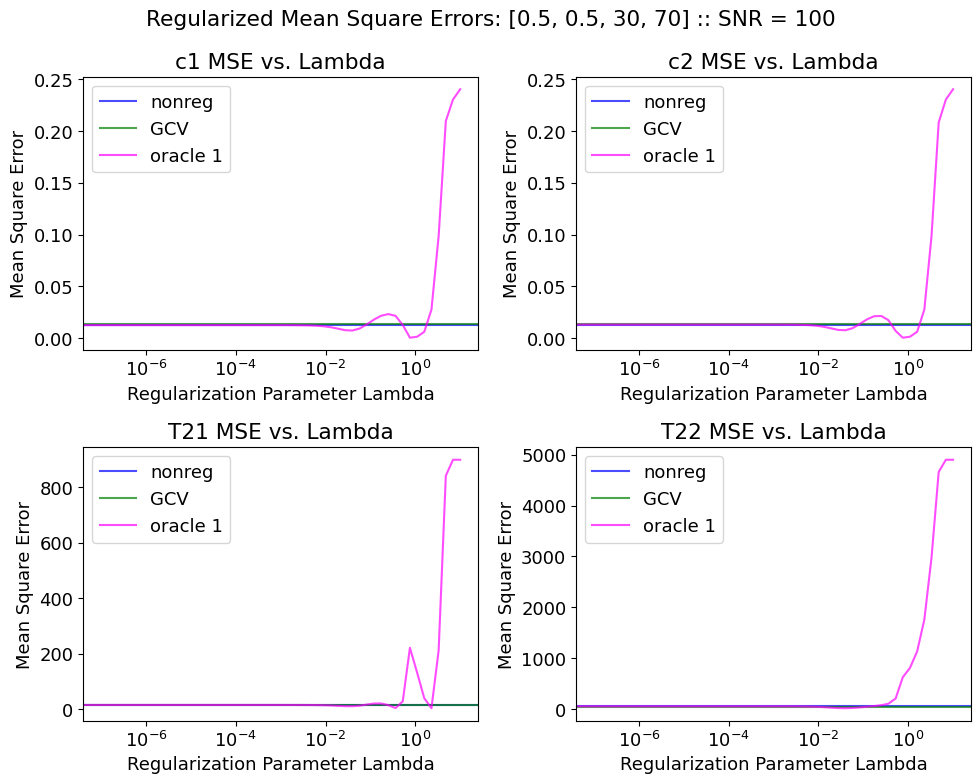

In [ ]:
pCombo_oi = [0.5,0.5,30,70]
pC_index = paramCombos.index(pCombo_oi)

single_pC_GCV_MSE = GCV_MSE[pC_index,:,:]
single_pC_orcAvg = orcAvg_MSE[pC_index,:,:,:]
single_pC_nonReg = nonreg_MSE[pC_index,:,:]

plt.rc('font', size = 13)
fig, ax = plt.subplots(2,2, figsize=(10,8), tight_layout=True)
fig.suptitle('Regularized Mean Square Errors: ' + str(pCombo_oi) + ' :: SNR = ' + str(SNR[0]))
for i in range(4):
    ax[i//2, i%2].axhline(y = single_pC_nonReg[0,i], label = "nonreg", alpha = 0.7, color = "blue")
    ax[i//2, i%2].axhline(y = single_pC_GCV_MSE[0,i], label = "GCV", alpha = 0.7, color = "green")
    ax[i//2, i%2].semilogx(lambdas, single_pC_orcAvg[0,:,i], label = "oracle 1", alpha = 0.7, color = "magenta")
    ax[i//2, i%2].set_xlabel('Regularization Parameter Lambda')
    ax[i//2, i%2].set_ylabel('Mean Square Error')
    ax[i//2, i%2].set_title(param_name_list[i] + ' MSE vs. Lambda')
    ax[i//2, i%2].legend()
plt.show()

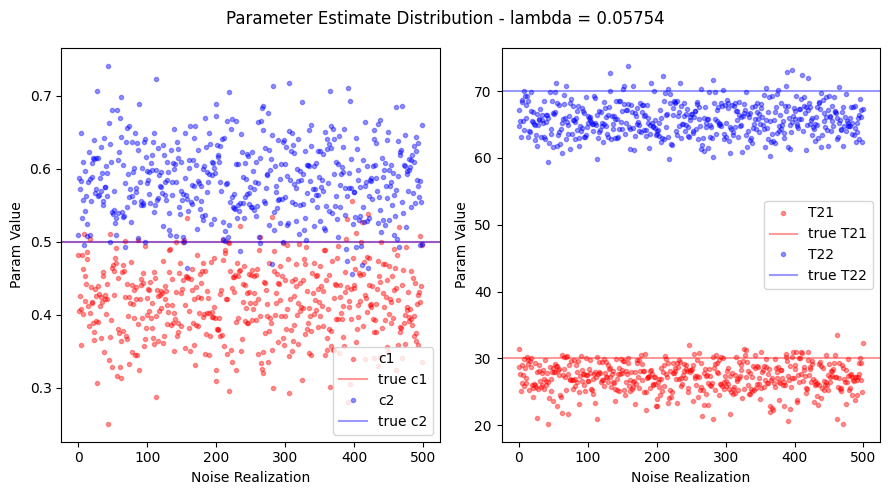

In [ ]:
lambda_val_oi = np.mean(GCV_lambdas, axis = 2)[pC_index,0]
lambda_oi = np.argmin((lambdas - lambda_val_oi )**2)

T21_outlier_index = np.where(complete_estimates[pC_index,0,:,lambda_oi,2]<pCombo_oi[2]//2)

plt.rc('font', size = 10)
fig, ax = plt.subplots(1, 2, figsize=(9,5), tight_layout=True)
fig.suptitle(f"Parameter Estimate Distribution - lambda = {np.round(lambdas[lambda_oi],5)}")
ax[0].plot(T21_outlier_index, complete_estimates[pC_index,0,T21_outlier_index,lambda_oi,0], color = "green", alpha = 0.5, ls = '', marker = 'o', markersize = 5)
ax[0].plot(T21_outlier_index, complete_estimates[pC_index,0,T21_outlier_index,lambda_oi,1], color = "green", alpha = 0.5, ls = '', marker = 'o', markersize = 5)
ax[0].plot(complete_estimates[pC_index,0,:,lambda_oi,0], color = "red", label = "c1", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[0], label = 'true c1', color = "red", alpha = 0.4)
ax[0].plot(complete_estimates[pC_index,0,:,lambda_oi,1], color = "blue", label = "c2", alpha = 0.4, ls = '', marker = '.')
ax[0].axhline(y = pCombo_oi[1], label = 'true c2', color = "blue", alpha = 0.4)
ax[0].set_xlabel("Noise Realization")
ax[0].set_ylabel("Param Value")
ax[0].legend()

ax[1].plot(T21_outlier_index, complete_estimates[pC_index,0,T21_outlier_index,lambda_oi,2], color = "green", alpha = 0.5, ls = '', marker = 'o', markersize = 5)
ax[1].plot(T21_outlier_index, complete_estimates[pC_index,0,T21_outlier_index,lambda_oi,3], color = "green", alpha = 0.5, ls = '', marker = 'o', markersize = 5)
ax[1].plot(complete_estimates[pC_index,0,:,lambda_oi,2], color = "red", label = "T21", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[2], label = 'true T21', color = "red", alpha = 0.4)
ax[1].plot(complete_estimates[pC_index,0,:,lambda_oi,3], color = "blue", label = "T22", alpha = 0.4, ls = '', marker = '.')
ax[1].axhline(y = pCombo_oi[3], label = 'true T22', color = "blue", alpha = 0.4)
ax[1].set_xlabel("Noise Realization")
ax[1].set_ylabel("Param Value")
ax[1].legend()

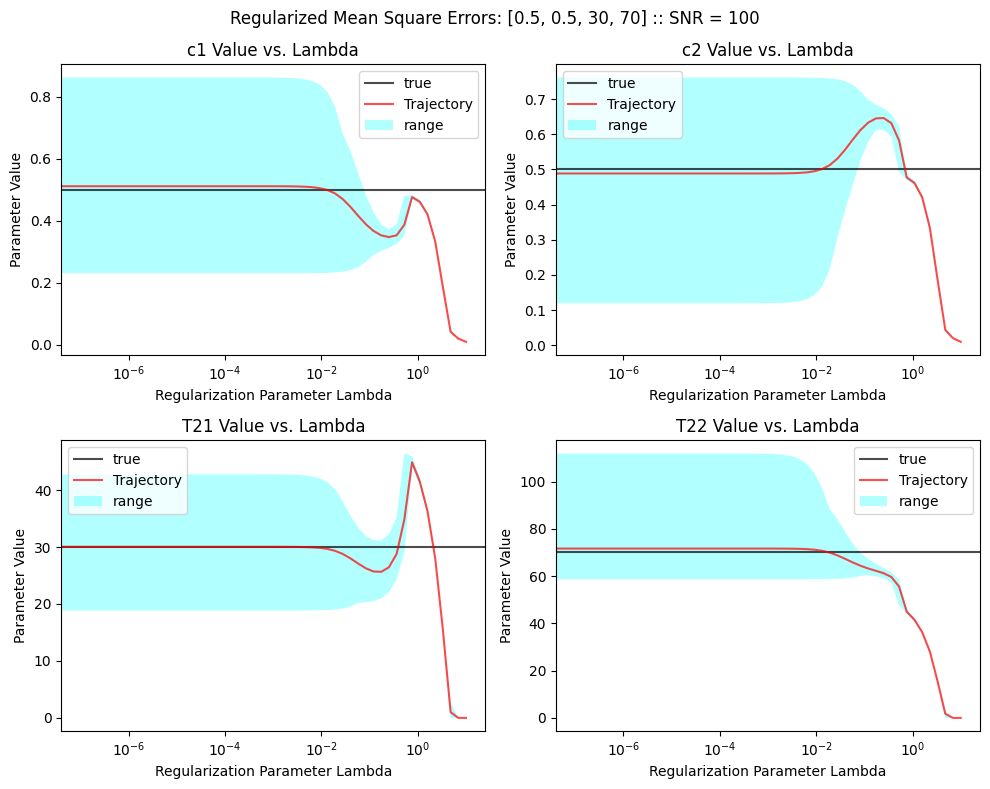

In [ ]:
single_meanParam = np.mean(complete_estimates[pC_index,0,:,:,:], axis = 0)
single_stdParam = np.std(complete_estimates[pC_index,0,:,:,:], axis = 0)
single_minParam = np.min(complete_estimates[pC_index,0,:,:,:], axis = 0)
single_maxParam = np.max(complete_estimates[pC_index,0,:,:,:], axis = 0)

plt.rc('font', size = 10)
fig, ax = plt.subplots(2,2, figsize=(10,8), tight_layout=True)
fig.suptitle('Regularized Mean Square Errors: ' + str(pCombo_oi) + ' :: SNR = ' + str(SNR[0]))
for i in range(4):
    ax[i//2, i%2].axhline(y = pCombo_oi[i], label = "true", alpha = 0.7, color = "black")
    ax[i//2, i%2].semilogx(lambdas, single_meanParam[:,i], label = "Trajectory", alpha = 0.7, color = "red")
    ax[i//2, i%2].fill_between(lambdas, single_minParam[:,i], single_maxParam[:,i], color = 'cyan', alpha = 0.3, lw=0, label = 'range')
    ax[i//2, i%2].set_xlabel('Regularization Parameter Lambda')
    ax[i//2, i%2].set_ylabel('Parameter Value')
    ax[i//2, i%2].set_title(param_name_list[i] + ' Value vs. Lambda')
    ax[i//2, i%2].legend()
plt.show()

# Show Improvements

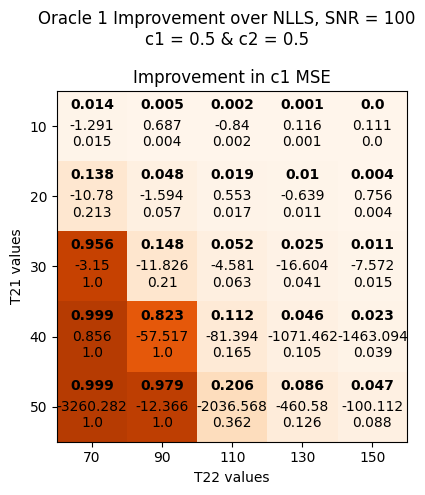

In [ ]:
if eval_orc_avg:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), len(SNR), 4]

    POI = 0
    orcAvg_imp_MSE = np.reshape(orcAvg_imp_MSE,size_array)
    orcAvg_imp_bias_sq = np.reshape(orcAvg_imp_bias_sq,np.abs(size_array))
    orcAvg_imp_var = np.reshape(orcAvg_imp_var,size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        plt.rc('font', size = 10)
        fig.suptitle(f"Oracle 1 Improvement over NLLS, SNR = {SNR[0]}\nc1 = {c1_set[c1_VOI]} & c2 = {1 - c1_set[c1_VOI]}")
        imc1 = ax.imshow(orcAvg_imp_MSE[c1_VOI,:,:,0,POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

        ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                MSE_summary = (f"{round(orcAvg_imp_MSE[c1_VOI,i,j,0,POI], 3)}")
                comp_summary = (f"\n{round(orcAvg_imp_bias_sq[c1_VOI,i,j,0,POI], 3)}\n{round(orcAvg_imp_var[c1_VOI,i,j,0,POI], 3)}")
                text = ax.text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")

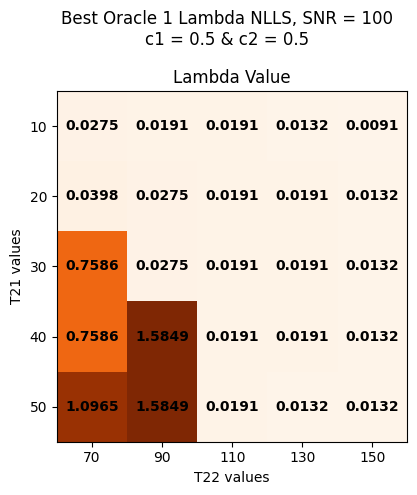

In [ ]:
if eval_orc_avg:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), len(SNR), 4]

    POI = 0
    minMSE_orcAvg_lamb = np.reshape(minMSE_orcAvg_lamb ,size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        fig.suptitle(f"Best Oracle 1 Lambda NLLS, SNR = {SNR[0]}\nc1 = {c1_set[c1_VOI]} & c2 = {1 - c1_set[c1_VOI]}")
        imc1 = ax.imshow(minMSE_orcAvg_lamb[c1_VOI,:,:,0, POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

        ax.set_title('Lambda Value')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                lamb_summary = (f"{round(minMSE_orcAvg_lamb[c1_VOI,i,j,0, POI], 4)}")
                text = ax.text(j, i, lamb_summary, ha="center", va="center", color="black", weight = "bold")

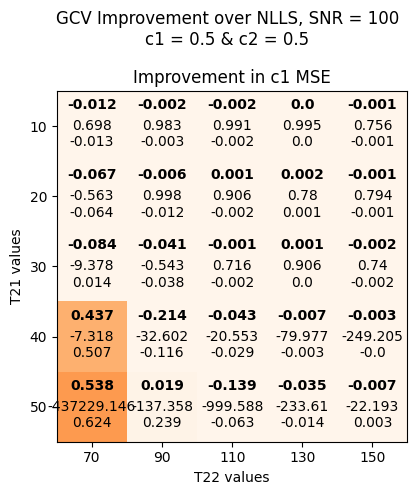

In [ ]:
if eval_GCV:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), len(SNR), 4]

    POI = 0
    GCV_imp_MSE = np.reshape(GCV_imp_MSE,size_array)
    GCV_imp_bias_sq = np.reshape(GCV_imp_bias_sq,size_array)
    GCV_imp_var = np.reshape(GCV_imp_var,size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        fig.suptitle(f"GCV Improvement over NLLS, SNR = {SNR[0]}\nc1 = {c1_set[c1_VOI]} & c2 = {1 - c1_set[c1_VOI]}")
        imc1 = ax.imshow(GCV_imp_MSE[c1_VOI,:,:,0,POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

        ax.set_title('Improvement in ' + param_name_list[POI] + ' MSE')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                MSE_summary = (f"{round(GCV_imp_MSE[c1_VOI,i,j,0,POI], 3)}")
                comp_summary = (f"\n{round(GCV_imp_bias_sq[c1_VOI,i,j,0,POI], 3)}\n{round(GCV_imp_var[c1_VOI,i,j,0,POI], 3)}")
                text = ax.text(j, i-0.3, MSE_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")

    # with h5py.File(f'SimulationSets//GCV//streamlined_fig2set_{SNR}_' + day + month + year +'.hdf5','a') as f:
    #     #Save a data set
    #     # dset = f.create_dataset('runInfo',data=runInfo)
    #     dset = f.create_dataset('MSE_array',data=GCV_MSE)
    #     dset = f.create_dataset('lambda_array',data=GCV_lambdas)
    #     dset = f.create_dataset('improvement_array',data=GCV_imp_MSE)
    #     dset = f.create_dataset('bias_improvement_array',data=GCV_imp_bias)
    #     dset = f.create_dataset('variance_improvement_array',data=GCV_imp_var)



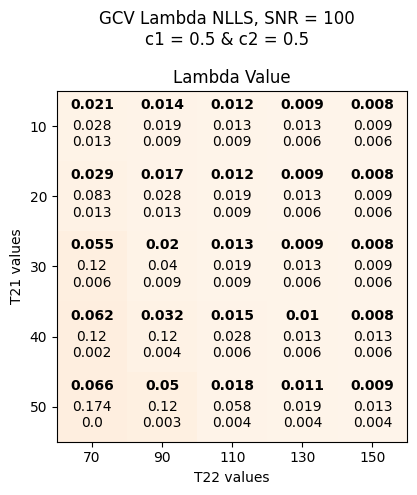

In [ ]:
if eval_GCV:
    #Parameter of interest, using the standard indexing for this code

    size_array = [np.size(c1_set),np.size(T21_set),np.size(T22_set), len(SNR)]

    POI = 0
    GCV_lambdas_mean = np.reshape(np.mean(GCV_lambdas, axis = 2), size_array)
    GCV_lambdas_min = np.reshape(np.min(GCV_lambdas, axis = 2), size_array)
    GCV_lambdas_max = np.reshape(np.max(GCV_lambdas, axis = 2), size_array)
    for c1_VOI in range(size_array[0]):
        fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
        fig.suptitle(f"GCV Lambda NLLS, SNR = {SNR[0]}\nc1 = {c1_set[c1_VOI]} & c2 = {1 - c1_set[c1_VOI]}")
        imc1 = ax.imshow(GCV_lambdas_mean[c1_VOI,:,:,0], cmap = 'Oranges', vmin = 0, vmax = 1.2)

        ax.set_title('Lambda Value')
        ax.set_xticks(np.arange(len(T22_set)))
        ax.set_yticks(np.arange(len(T21_set)))
        ax.set_xticklabels(T22_set)
        ax.set_yticklabels(T21_set)
        ax.set_ylabel('T21 values')
        ax.set_xlabel('T22 values')

        for i in range(len(T21_set)):
            for j in range(len(T22_set)):
                lamb_summary = (f"{round(GCV_lambdas_mean[c1_VOI,i,j,0], 3)}")
                comp_summary = (f"\n{round(GCV_lambdas_max[c1_VOI,i,j,0], 3)}\n{round(GCV_lambdas_min[c1_VOI,i,j,0], 3)}")
                text = ax.text(j, i-0.3, lamb_summary, ha="center", va="center", color="black", weight = "bold")
                text2 = ax.text(j, i, comp_summary, ha="center", va="center", color="black")

In [ ]:
####### All unregularized code

if load_unreg:
    print("TODO")
else:
    start_time = time.time()
    unreg_bias, unreg_var, _ = make_patchwork_sinNR(paramCombos, data_combo, lambdas, 'unreg', verbose = True)
    print('Unreg time:', (time.time()-start_time)/60, ' minutes')

Calculating combo 1 of 2: 50.0%: Projected time left 0.0min


100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


Calculating combo 2 of 2: 100.0%: Projected time left 0.0min


100%|██████████| 10/10 [00:01<00:00,  6.58it/s]

Unreg time: 0.09410152037938437  minutes


In [ ]:
if load_fig2:
    if avgNR_opt:
        print('TODO')

    if sinNR_opt:
        print('TODO')

    if GCV_opt:
        with h5py.File(f'SimulationSets//GCV//fig2set_100_10Nov22.hdf5','a') as f:
            #Save a data set
            # dset = f.create_dataset('runInfo',data=runInfo)
            GCV_MSE_array = np.array(f['MSE_array'])
            GCV_lambda_array = np.array(f['lambda_array'])
            GCV_imp_array = np.array(f['improvement_array'])
        with open('SimulationSets//GCV//runInfo_100_10Nov22.pkl', 'rb') as handle:
            dict = pickle.load(handle)
        SNR = dict['SNR']

else:
    if avgNR_opt:
        start_time = time.time()
        avgNR_bias, avgNR_var = make_patchwork_avgNR(paramCombos, lambdas, verbose=False)
        print('Min MSE time:', (time.time()-start_time)/60, ' minutes')

    if sinNR_opt:
        start_time = time.time()
        sinNR_bias, sinNR_var, sinNR_lambdas = make_patchwork_sinNR(paramCombos, data_combo, lambdas, 'oracle', aggregate=True)
        print('Oracle time:', (time.time()-start_time)/60, ' minutes')

    if GCV_opt:
        start_time = time.time()
        GCV_bias, GCV_var, GCV_lambdas = make_patchwork_sinNR(paramCombos, data_combo, lambdas, 'GCV', verbose = True)
        GCV_MSE, unreg_MSE, GCV_imp_MSE, GCV_imp_bias, GCV_imp_var = compare_MSE(GCV_bias, GCV_var, unreg_bias, unreg_var)
        print('GCV time:', (time.time()-start_time)/60, ' minutes')


# model = load_model('DNN Networks//reg_model SNR 100 3-23.h5')
# DNN_MSE_array, DNN_lambda_array, DNN_imp_array = make_patchwork_sinNR(
    # c1_set, c2_set, T21_set, T22_set, lambdas, 'DNN', model=model)


############# Functions 

100%|██████████| 52/52 [01:22<00:00,  1.59s/it]


Min MSE time: 3.7798853278160096  minutes


100%|██████████| 10/10 [01:18<00:00,  7.83s/it]


Oracle time: 3.7576871593793233  minutes
Calculating combo 1 of 2: 50.0%: Projected time left 0.0min


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


Calculating combo 2 of 2: 100.0%: Projected time left 0.0min


100%|██████████| 10/10 [00:08<00:00,  1.23it/s]

GCV time: 0.38808435599009194  minutes


In [ ]:
if sinNR_opt:
    #Parameter of interest, using the standard indexing for this code

    MSE, unreg_MSE, min_MSE = process_avgNR(avgNR_bias, avgNR_var, lambdas)
    oracle_imp_array = calc_improvment(unreg_MSE, MSE)

    POI = 0
    fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
    fig.suptitle("Oracle Improvement over NLLS, SNR = %s" % SNR)
    imc1 = ax.imshow(oracle_imp_array[0,0,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

    ax.set_title('Improvement in c1 MSE')
    ax.set_xticks(np.arange(len(T22_set)))
    ax.set_yticks(np.arange(len(T21_set)))
    ax.set_xticklabels(T22_set)
    ax.set_yticklabels(T21_set)
    ax.set_ylabel('T21 values')
    ax.set_xlabel('T22 values')

    for i in range(len(T21_set)):
        for j in range(len(T22_set)):
            text = ax.text(j, i, round(oracle_imp_array[0,0,i,j,0], 3), ha="center", va="center", color="black")

    with h5py.File(f'SimulationSets//oracle//fig2set_{SNR}_' + day + month + year +'.hdf5','a') as f:
        #Save a data set
        dset = f.create_dataset('runInfo',data=runInfo)
        dset = f.create_dataset('MSE_array',data=oracle_MSE_array)
        dset = f.create_dataset('lambda_array',data=oracle_lambda_array)
        dset = f.create_dataset('improvement_array',data=oracle_imp_array)

ValueError: operands could not be broadcast together with shapes (2,4) (2,52,4) 

In [ ]:
if avgNR_opt:
    #Parameter of interest, using the standard indexing for this code
    POI = 0
    fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
    fig.suptitle("min MSE Improvement over NLLS, SNR = %s" % SNR)
    imc1 = ax.imshow(min_MSE_imp_array[0,0,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

    ax.set_title('Improvement in c1 MSE')
    ax.set_xticks(np.arange(len(T22_set)))
    ax.set_yticks(np.arange(len(T21_set)))
    ax.set_xticklabels(T22_set)
    ax.set_yticklabels(T21_set)
    ax.set_ylabel('T21 values')
    ax.set_xlabel('T22 values')

    for i in range(len(T21_set)):
        for j in range(len(T22_set)):
            text = ax.text(j, i, round(min_MSE_imp_array[0,0,i,j,0], 3), ha="center", va="center", color="black")

    with h5py.File(f'SimulationSets//minMSE//fig2set_{SNR}_' + day + month + year +'.hdf5','a') as f:
        #Save a data set
        dset = f.create_dataset('runInfo',data=runInfo)
        dset = f.create_dataset('MSE_array',data=min_MSE_array)
        dset = f.create_dataset('lambda_array',data=min_lambda_array)
        dset = f.create_dataset('improvement_array',data=min_MSE_imp_array)
        dset = f.create_dataset('unreg_MSE_array',data=unreg_MSE_array)

c:\co\NIA\.grif_venv\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 27 () missing from current font.
  func(*args, **kwargs)
c:\co\NIA\.grif_venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 27 () missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


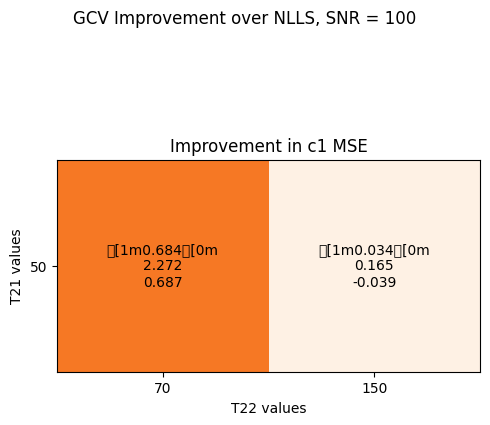

In [ ]:
if GCV_opt:
    #Parameter of interest, using the standard indexing for this code
    POI = 0
    GCV_imp_MSE = np.reshape(GCV_imp_MSE,size_array)
    GCV_imp_bias = np.reshape(np.abs(GCV_imp_bias),np.abs(size_array))
    GCV_imp_var = np.reshape(GCV_imp_var,size_array)
    fig, ax = plt.subplots(figsize = (5, 5), tight_layout=True)
    fig.suptitle("GCV Improvement over NLLS, SNR = %s" % SNR)
    imc1 = ax.imshow(GCV_imp_MSE[c1_VOI,:,:,POI], cmap = 'Oranges', vmin = 0, vmax = 1.2)

    ax.set_title('Improvement in c1 MSE')
    ax.set_xticks(np.arange(len(T22_set)))
    ax.set_yticks(np.arange(len(T21_set)))
    ax.set_xticklabels(T22_set)
    ax.set_yticklabels(T21_set)
    ax.set_ylabel('T21 values')
    ax.set_xlabel('T22 values')

    for i in range(len(T21_set)):
        for j in range(len(T22_set)):
            MSE_summary = ("\033[1m" + f"{round(GCV_imp_MSE[c1_VOI,i,j,POI], 3)}" + "\033[0m" + f"\n{round(GCV_imp_bias[c1_VOI,i,j,POI], 3)}\n{round(GCV_imp_var[c1_VOI,i,j,POI], 3)}")
            text = ax.text(j, i, MSE_summary, ha="center", va="center", color="black")

    # with h5py.File(f'SimulationSets//GCV//streamlined_fig2set_{SNR}_' + day + month + year +'.hdf5','a') as f:
    #     #Save a data set
    #     # dset = f.create_dataset('runInfo',data=runInfo)
    #     dset = f.create_dataset('MSE_array',data=GCV_MSE)
    #     dset = f.create_dataset('lambda_array',data=GCV_lambdas)
    #     dset = f.create_dataset('improvement_array',data=GCV_imp_MSE)
    #     dset = f.create_dataset('bias_improvement_array',data=GCV_imp_bias)
    #     dset = f.create_dataset('variance_improvement_array',data=GCV_imp_var)



In [ ]:
#POI = 0
# fig, ax = plt.subplots(2, 2, figsize = (10, 10), tight_layout=True)
# fig.suptitle("DNN improvement over NLLS, SNR = %s" % SNR)
# imc1 = ax[0,0].imshow(DNN_imp_array[0,0,:,:,0])
# imc2 = ax[0,1].imshow(DNN_imp_array[0,0,:,:,1])
# imT21 = ax[1,0].imshow(DNN_imp_array[0,0,:,:,2])
# imT22 = ax[1,1].imshow(DNN_imp_array[0,0,:,:,3])

# ax[0,0].set_title('Improvement in c1 MSE')
# ax[0,0].set_xticks(np.arange(len(T22_set)))
# ax[0,0].set_yticks(np.arange(len(T21_set)))
# ax[0,0].set_xticklabels(T22_set)
# ax[0,0].set_yticklabels(T21_set)
# ax[0,0].set_ylabel('T21 values')
# ax[0,0].set_xlabel('T22 values')

# for i in range(len(T21_set)):
#     for j in range(len(T22_set)):
#         text = ax[0,0].text(j, i, round(DNN_imp_array[0,0,i,j,0], 2), ha="center", va="center", color="red")
        
# ax[1,0].set_title('Improvement in c2 MSE')
# ax[1,0].set_xticks(np.arange(len(T22_set)))
# ax[1,0].set_yticks(np.arange(len(T21_set)))
# ax[1,0].set_xticklabels(T22_set)
# ax[1,0].set_yticklabels(T21_set)
# ax[1,0].set_ylabel('T21 values')
# ax[1,0].set_xlabel('T22 values')

# for i in range(len(T21_set)):
#     for j in range(len(T22_set)):
#         text = ax[1,0].text(j, i, round(DNN_imp_array[0,0,i,j,1], 2), ha="center", va="center", color="red")
        
# ax[0,1].set_title('Improvement in T21 MSE')
# ax[0,1].set_xticks(np.arange(len(T22_set)))
# ax[0,1].set_yticks(np.arange(len(T21_set)))
# ax[0,1].set_xticklabels(T22_set)
# ax[0,1].set_yticklabels(T21_set)
# ax[0,1].set_ylabel('T21 values')
# ax[0,1].set_xlabel('T22 values')

# for i in range(len(T21_set)):
#     for j in range(len(T22_set)):
#         text = ax[0,1].text(j, i, round(DNN_imp_array[0,0,i,j,2], 2), ha="center", va="center", color="red")
        
# ax[1,1].set_title('Improvement in T22 MSE')
# ax[1,1].set_xticks(np.arange(len(T22_set)))
# ax[1,1].set_yticks(np.arange(len(T21_set)))
# ax[1,1].set_xticklabels(T22_set)
# ax[1,1].set_yticklabels(T21_set)
# ax[1,1].set_ylabel('T21 values')
# ax[1,1].set_xlabel('T22 values')

# for i in range(len(T21_set)):
#     for j in range(len(T22_set)):
#         text = ax[1,1].text(j, i, round(DNN_imp_array[0,0,i,j,3], 2), ha="center", va="center", color="red")
# plt.show()

##### Exploring the corner cases

In [ ]:
if explore_corners:

    c1_set = [0.5]
    c2_set = [0.5]
    T21_set1 = [10]
    T22_set1 = [150]

    T21_set2 = [50]
    T22_set2 = [70]

    n_opt = 25
    n_iters = np.linspace(500//n_opt,500,25)
    iter_length = np.size(n_iters)

    oracle_topRight_MSE = np.zeros((iter_length,4))
    oracle_botLeft_MSE = np.zeros((iter_length,4))
    GCV_topRight_MSE = np.zeros((iter_length,4))
    GCV_botLeft_MSE = np.zeros((iter_length,4))

    for i in trange(iter_length):

        iter_size = n_iters[i]

        oracle_MSE_array, oracle_lambda_array, oracle_imp_array = make_patchwork_sinNR(
            c1_set, c2_set, T21_set1, T22_set1, lambdas, 'oracle', aggregate=True, noise_iterations = iter_size)
        oracle_topRight_MSE[i,:] = oracle_MSE_array[0,0,0,0,:]
            
        GCV_MSE_array, GCV_lambda_array, GCV_imp_array = make_patchwork_sinNR(
            c1_set, c2_set, T21_set1, T22_set1, lambdas, 'GCV', noise_iterations = iter_size)
        GCV_topRight_MSE[i,:] =  GCV_MSE_array[0,0,0,0,:]

        oracle_MSE_array, oracle_lambda_array, oracle_imp_array = make_patchwork_sinNR(
            c1_set, c2_set, T21_set2, T22_set2, lambdas, 'oracle', aggregate=True, noise_iterations = iter_size)
        oracle_botLeft_MSE[i,:] = oracle_MSE_array[0,0,0,0,:]
            
        GCV_MSE_array, GCV_lambda_array, GCV_imp_array = make_patchwork_sinNR(
            c1_set, c2_set, T21_set2, T22_set2, lambdas, 'GCV', noise_iterations = iter_size)
        GCV_botLeft_MSE[i,:] =  GCV_MSE_array[0,0,0,0,:]

In [ ]:
if explore_corners:
    save_MSE_array = False
    load_MSE_array = False
    n_iters = np.arange(10,501,10)

    if save_MSE_array:
        try:
            with h5py.File('Storage//CornerCases.hdf5','a') as f:
                #Save a data set
                dset = f.create_dataset('oracle_topRight',data=oracle_topRight_MSE)
                dset = f.create_dataset('oracle_botLeft',data=oracle_botLeft_MSE)
                dset = f.create_dataset('GCV_topRight',data=GCV_topRight_MSE)
                dset = f.create_dataset('GCV_botLeft',data=GCV_botLeft_MSE)
        except:
            print("Error")

    if load_MSE_array:
        with h5py.File('Storage//CornerCases.hdf5','a') as f:
            oracle_topRight_MSE = np.array(f['oracle_topRight'])
            oracle_botLeft_MSE = np.array(f['oracle_botLeft'])
            GCV_topRight_MSE = np.array(f['GCV_topRight'])
            GCV_botLeft_MSE = np.array(f['GCV_botLeft'])

In [ ]:
if explore_corners:
    fig, ax = plt.subplots(1,2,figsize=(10,5), tight_layout=True)
    fig.suptitle('MSE Compared to Iteration')
    ax[0].plot(n_iters, oracle_topRight_MSE[:,0], label= 'Oracle TopRight', alpha = 0.7)
    ax[0].plot(n_iters, GCV_topRight_MSE[:,0], label= 'GCV TopRight', alpha = 0.7)
    ax[1].plot(n_iters, oracle_botLeft_MSE[:,0], label= 'Oracle BotLeft', alpha = 0.7)
    ax[1].plot(n_iters, GCV_botLeft_MSE[:,0], label= 'GCV BotLeft', alpha = 0.7)
    ax[0].set_xlabel('Number of Iterations')
    ax[0].set_ylabel('MSE')
    ax[0].set_title('T21 = 10 & T22 = 150')
    ax[1].set_xlabel('Number of Iterations')
    ax[1].set_ylabel('MSE')
    ax[1].set_title('T21 = 50 & T22 = 70')
    ax[0].legend()
    ax[1].legend()
    plt.show()

# Use a numerical method to calculate the biased CRLB

In [ ]:
def construct_P_theta_n(theta_n, c_range, T2_range, M):
    #theta_n are the 4 parameters to perturb around, given as a numpy array
    #c_range and T2_range are define the range of the perturbations about ci and T2i
    #M is the number of total perturbations
    #The first entry in P_theta_n is always just theta_n
    P_theta_n = np.zeros((4, M+1))
    P_theta_n[:,0] = theta_n
    for m in range(M):
        a1_m = np.random.uniform(low=c_range[0],high=c_range[1])
        a2_m = np.random.uniform(low=c_range[0],high=c_range[1])
        tau1_m = np.random.uniform(low=T2_range[0],high=T2_range[1])
        tau2_m = np.random.uniform(low=T2_range[0],high=T2_range[1])
        
        T_theta_nm = np.append(a1_m, [a2_m, tau1_m, tau2_m])
        
        P_theta_n[:, m+1] = theta_n + T_theta_nm
        
    return P_theta_n

def construct_A_n(P_theta_n):
    #Gives matrix A_n for least squares minimization to get biased CRLB for parameters theta_n
    #P_theta_n is the perturbation matrix about some theta_n
    M = P_theta_n.shape[1]-1
    theta_n = P_theta_n[:,0]
    
    #Get first four rows of A_n first
    z = P_theta_n[:,1] - theta_n
    B1 = [z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0,0,0]
    B2 = [0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0,0]
    B3 = [0,0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0]
    B4 = [0,0,0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3]]
    A_n = np.stack((B1, B2, B3, B4),axis=0)
    #Then get the rest of the rows
    for m in range(M-1):
        z = P_theta_n[:,m+2] - theta_n
        B1 = [z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0,0,0]
        B2 = [0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0,0]
        B3 = [0,0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3],0]
        B4 = [0,0,0,z[0],0,0,0,z[1],0,0,0,z[2],0,0,0,z[3]]
        
        B_mn = np.stack((B1, B2, B3, B4), axis=0)
        A_n = np.concatenate((A_n, B_mn),axis=0)
        
    return A_n

def run_NR_P_theta_n(P_theta_n, n_noise_realizations):
    M = P_theta_n.shape[1]
    estimates = np.zeros((4, M, n_noise_realizations))
    for m in range(M):
        [c1, c2, T21, T22] = P_theta_n[:,m]
        
        #np.random.seed(m)
        noiseless_curve = G(tdata, c1, c2, T21, T22)
        for i in range(n_noise_realizations):
            noise_realization = add_noise(noiseless_curve, SNR)
            est = estimate_parameters(noise_realization, 0)
            estimates[:,m,i] = est
    return estimates

def x_cost_fun(bias_var_n, A_n):
    def function(x):
        #For giving least squares the vector of the residual
        return (bias_var_n - A_n@x)
    return function

def biased_CRLB(theta_n, c_range, T2_range, M, n_noise_realizations):
    #Calculates the biased CRLB about a set of parameters theta_n
    P_theta_n = construct_P_theta_n(theta_n, c_range, T2_range, M)
    estimates = run_NR_P_theta_n(P_theta_n, n_noise_realizations)
    
    sample_mean = np.mean(estimates,axis=-1)
    Q_0 = sample_mean[:,0]
    sample_mean_shortened = sample_mean[:,1:]
    
    bias_var_n = np.reshape((sample_mean_shortened.transpose() - Q_0),-1)
    
    A_n = construct_A_n(P_theta_n)
    
    minimization = x_cost_fun(bias_var_n, A_n)
    x_hat_n = least_squares(minimization, np.zeros(16))['x']
    
    #x_hat_n = (np.linalg.inv(A_n.transpose()@A_n)@A_n.transpose())@bias_var_n
    S_hat_n = np.transpose(np.reshape(x_hat_n, (4,4)))
    CRLB_n = cov_matrix(theta_n[0],theta_n[1],theta_n[2],theta_n[3], SNR)

    biased_CRLB = S_hat_n@CRLB_n@S_hat_n.transpose()
    
    return biased_CRLB, S_hat_n

def check_CRLB_convergence(n_set, theta_n, c_range, T2_range, M, verbose=False):
    n_checks = len(n_set)
    P_theta_n = construct_P_theta_n(theta_n, c_range, T2_range, M)
    CRLB_n = cov_matrix(theta_n[0],theta_n[1],theta_n[2],theta_n[3], SNR)
    biased_CRLB_set = []
    c1_CRLB_set = []
    c2_CRLB_set = []
    T21_CRLB_set = []
    T22_CRLB_set = []
    sensitivity_set = []
    for i in trange(n_checks):
        if i == 0:
            n_noise_realizations = n_set[i]
            estimates = run_NR_P_theta_n(P_theta_n, n_noise_realizations)
        else:
            n_noise_realizations = n_set[i] - n_set[i-1]
            new_estimates = run_NR_P_theta_n(P_theta_n, n_noise_realizations)
            estimates = np.append(estimates, new_estimates,axis=-1)
        sample_mean = np.mean(estimates, axis=-1)
        Q_0 = sample_mean[:,0]
        sample_mean_shortened = sample_mean[:,1:]
        bias_var_n = np.reshape((sample_mean_shortened.transpose() - Q_0),-1)
        A_n = construct_A_n(P_theta_n)
        
        minimization = x_cost_fun(bias_var_n, A_n)
        x_hat_n = least_squares(minimization, np.zeros(16))['x']
        S_hat_n = np.transpose(np.reshape(x_hat_n, (4,4)))
        sensitivity_set.append(S_hat_n)

        biased_CRLB = S_hat_n@CRLB_n@(S_hat_n.transpose())
        biased_CRLB_set.append(biased_CRLB)
        
        c1_CRLB = biased_CRLB[0,0]
        c1_CRLB_set.append(c1_CRLB)
        c2_CRLB = biased_CRLB[1,1]
        c2_CRLB_set.append(c2_CRLB)
        T21_CRLB = biased_CRLB[2,2]
        T21_CRLB_set.append(T21_CRLB)
        T22_CRLB = biased_CRLB[3,3] 
        T22_CRLB_set.append(T22_CRLB)
        if verbose:
            print('Biased CRLB at %s noise realizations:'%(n_set[i]), c1_CRLB, c2_CRLB, T21_CRLB, T22_CRLB)
            
    return biased_CRLB_set, c1_CRLB_set, c2_CRLB_set, T21_CRLB_set, T22_CRLB_set, sensitivity_set

In [ ]:
theta_n = np.array((0.3, 0.7, 50, 90))
c_range = [-0.05, 0.05]
T2_range = [-2.5, 2.5]
M = 10
n_noise_realizations = 100

CRLB_n = cov_matrix(theta_n[0],theta_n[1],theta_n[2],theta_n[3], SNR)
biased_CRLB_n, sensitivity = biased_CRLB(theta_n, c_range, T2_range, M, n_noise_realizations)

In [ ]:
#Check for convergence
theta_n = np.array((0.5, 0.5, 20, 200))
c_range = [-0.05, 0.05]
T2_range = [-2.5, 2.5]
M = 10
n_set = np.linspace(100, 100000, 1000, dtype=int)
biased_CRLB_set, c1_CRLB_set, c2_CRLB_set, T21_CRLB_set, T22_CRLB_set, sensitivity_set = check_CRLB_convergence(
    n_set, theta_n, c_range, T2_range, M, verbose=False)

 30%|███       | 305/1000 [6:13:29<14:11:03, 73.47s/it] 


KeyboardInterrupt: 

In [ ]:
CRLB_n = cov_matrix(theta_n[0],theta_n[1],theta_n[2],theta_n[3], SNR)
c1_CRLB = CRLB_n[0,0]
c2_CRLB = CRLB_n[1,1]
T21_CRLB = CRLB_n[2,2]
T22_CRLB = CRLB_n[3,3]
fig, ax = plt.subplots(1,4,figsize=(18,4),tight_layout=True)
fig.suptitle('Convergence of biased CRLB at SNR %s'%SNR)
ax[0].plot(n_set, c1_CRLB_set, label='c1 biased CRLB')
ax[0].axhline(y=c1_CRLB, label = 'c1 CRLB', color='r')
ax[0].set_xlabel('Noise realizations')
ax[0].set_ylabel('CRLB')
ax[0].set_title('c1 convergence')
ax[0].legend()
ax[1].plot(n_set, c2_CRLB_set, label='c2 biased CRLB')
ax[1].axhline(y=c2_CRLB, label = 'c2 CRLB', color='r')
ax[1].set_xlabel('Noise realizations')
ax[1].set_ylabel('CRLB')
ax[1].set_title('c2 convergence')
ax[1].legend()
ax[2].plot(n_set, T21_CRLB_set, label='T21 biased CRLB')
ax[2].axhline(y=T21_CRLB, label = 'T21 CRLB', color='r')
ax[2].set_xlabel('Noise realizations')
ax[2].set_ylabel('CRLB')
ax[2].set_title('T21 convergence')
ax[2].legend()
ax[3].plot(n_set, T22_CRLB_set, label='T22 biased CRLB')
ax[3].axhline(y=T22_CRLB, label = 'T22 CRLB', color='r')
ax[3].set_xlabel('Noise realizations')
ax[3].set_ylabel('CRLB')
ax[3].set_title('T22 convergence')
ax[3].legend()

plt.show()

In [ ]:
# with h5py.File('Brain MWF Maps//Biased CRLB SNR 1 Convergence, 1e5 NR 5-22.hdf5','a') as f2:
#     f2.create_dataset('biased CRLB', data=biased_CRLB_set)
#     f2.create_dataset('sensitivity', data=sensitivity_set)